# Proyecto de Tesis

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

from torch_scatter import  scatter_max

import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## CNN

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(torchvision.datasets.MNIST('./Convolucional', train=True, download=True,
                       transform = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      ), batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(torchvision.datasets.MNIST('./Convolucional', train=False, download=True,
                     transform = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     ), batch_size=64, shuffle=False, pin_memory=True)
}

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./Convolucional/MNIST/raw/train-images-idx3-ubyte.gz to ./Convolucional/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./Convolucional/MNIST/raw/train-labels-idx1-ubyte.gz to ./Convolucional/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./Convolucional/MNIST/raw/t10k-images-idx3-ubyte.gz to ./Convolucional/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./Convolucional/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./Convolucional/MNIST/raw



In [ ]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv2 = block(64, 128)
    self.fc = torch.nn.Linear(128*7*7, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

In [ ]:
def fit(model, dataloader, epochs=5):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = torch.nn.CrossEntropyLoss()
  convTrainLossMean, convValLossMean, convTrainAccMean, convValAccMean = [0.0], [0.0], [0.0], [0.0]
  for epoch in range(1, epochs+1):
    model.train()
    convTrainLoss, convTrainAcc = [], []
    batches = dataloader['train']
    for batch in batches:
      X, y = batch
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      y_hat = model(X)
      loss = criterion(y_hat, y)
      loss.backward()
      optimizer.step()
      convTrainLoss.append(loss.item())
      acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
      convTrainAcc.append(acc)
    batches = dataloader['test']
    convValLoss, convValAcc = [], []
    model.eval()
    with torch.no_grad():
      for batch in batches:
        X, y = batch
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        convValLoss.append(loss.item())
        acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
        convValAcc.append(acc)
    convTrainLossMean.append(np.mean(convTrainLoss))
    convValLossMean.append(np.mean(convValLoss))
    convTrainAccMean.append(np.mean(convTrainAcc))
    convValAccMean.append(np.mean(convValAcc))
    print(f"Epoch {epoch}/{epochs} loss {np.mean(convTrainLoss):.5f} val_loss {np.mean(convValLoss):.5f} acc {np.mean(convTrainAcc):.5f} val_acc {np.mean(convValAcc):.5f}")
  return convTrainLossMean, convValLossMean, convTrainAccMean, convValAccMean

In [ ]:
CNNmodel = CNN()

epochs = 5

convTrainLoss, convValLoss, convTrainAcc, convValAcc = fit(CNNmodel, dataloader, epochs=epochs)

Epoch 1/5 loss 0.11227 val_loss 0.04234 acc 0.96570 val_acc 0.98666
Epoch 2/5 loss 0.03936 val_loss 0.02778 acc 0.98761 val_acc 0.98995
Epoch 3/5 loss 0.02698 val_loss 0.03255 acc 0.99127 val_acc 0.98875
Epoch 4/5 loss 0.02048 val_loss 0.04018 acc 0.99339 val_acc 0.98686
Epoch 5/5 loss 0.01603 val_loss 0.03335 acc 0.99454 val_acc 0.99035


In [ ]:
torch.save(CNNmodel.state_dict(), "/content/drive/MyDrive/Tesis/CNNmodel.pt")

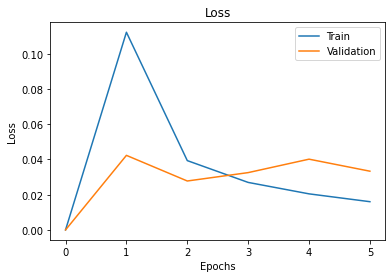

In [ ]:
ep = np.arange(0, epochs + 1,1)
plt.plot(ep, convTrainLoss, label="Train")
plt.plot(ep, convValLoss, label="Validation")

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

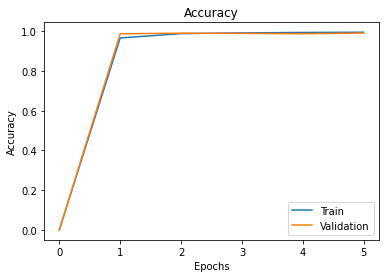

In [ ]:
ep = np.arange(0, epochs + 1,1)
plt.plot(ep, convTrainAcc, label="Train")
plt.plot(ep, convValAcc, label="Validation")

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

## GNN

In [ ]:
train = torchvision.datasets.MNIST('./GNN', train=True, download=True)
test = torchvision.datasets.MNIST('./GNN', train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./GNN/MNIST/raw/train-images-idx3-ubyte.gz to ./GNN/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./GNN/MNIST/raw/train-labels-idx1-ubyte.gz to ./GNN/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./GNN/MNIST/raw/t10k-images-idx3-ubyte.gz to ./GNN/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./GNN/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./GNN/MNIST/raw



In [ ]:
def createNodesandEdges(data, labels):
  listData = []
  for n, imgit in enumerate(data):
    imgit = imgit.numpy()
    imgit = np.where(imgit == 0, -1, imgit)
    imgit = np.pad(imgit, [(2, 2), (2, 2)], "constant", constant_values = (0))

    cnt = 0

    for i in range(2, 30):
      for j in range(2, 30):
        if (imgit[i][j] > -1):
          imgit[i][j] = cnt
          cnt = cnt + 1
    
    edges = []
    nodes = np.zeros((cnt, 2))

    for i in range(2, 30):
      for j in range(2, 30):
        if (imgit[i][j] == -1):
          continue

        filter = imgit[i - 2:i + 3, j - 2:j + 3].flatten()
        filterVal = filter[[6, 7, 8, 11, 13, 16, 17, 18]]

        nodes[filter[12]][0] = i - 2
        nodes[filter[12]][1] = j - 2

        for val in filterVal:
          if (not val == -1):
            edges.append([filter[12], val])

    edge = torch.tensor(np.array(edges).T, dtype=torch.long)
    node = torch.tensor(nodes/28, dtype=torch.float)

    d = Data(x=node, edge_index=edge.contiguous(), t=labels[n])
    listData.append(d)

    if(n % 1000 == 999):
      print("\rLoaded: " + str(n + 1), end=" ")
    
  print("Finished")
  return listData

In [ ]:
trainData = createNodesandEdges(train.data, train.targets)

Loaded: 60000 Finished


In [ ]:
testData = createNodesandEdges(test.data, test.targets)

Loaded: 10000 Finished


In [ ]:
dataloader = {
    'train': trainData,
    'test': testData
}

In [ ]:
class GCN(torch.nn.Module):
  def __init__(self):
    super(GCN, self).__init__()
    self.conv1 = GCNConv(2, 16)
    self.conv2 = GCNConv(16, 32)
    self.conv3 = GCNConv(32, 48)
    self.conv4 = GCNConv(48, 64)
    self.conv5 = GCNConv(64, 96)
    self.conv6 = GCNConv(96, 128)
    self.linear1 = torch.nn.Linear(128,64)
    self.linear2 = torch.nn.Linear(64,10)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = self.conv1(x, edge_index)
    x = torch.nn.functional.relu(x)

    x = self.conv2(x, edge_index)
    x = torch.nn.functional.relu(x)

    x = self.conv3(x, edge_index)
    x = torch.nn.functional.relu(x)

    x = self.conv4(x, edge_index)
    x = torch.nn.functional.relu(x)

    x = self.conv5(x, edge_index)
    x = torch.nn.functional.relu(x)

    x = self.conv6(x, edge_index)
    x = torch.nn.functional.relu(x)
        
    x, _ = scatter_max(x, data.batch, dim=0)
    x = self.linear1(x)
    x = torch.nn.functional.relu(x)

    x = self.linear2(x)
    return x

In [ ]:
def fit(model, dataloader, batch_size, epochs=5):
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters())
  criterion = torch.nn.CrossEntropyLoss()
  
  trainset = dataloader['train']
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  
  testset = dataloader['test']
  testloader = DataLoader(testset, batch_size=batch_size)

  gcnTrainLossMean, gcnValLossMean, gcnTrainAccMean, gcnValAccMean = [0.0], [0.0], [0.0], [0.0]

  for epoch in range(1, epochs+1):
    model.train()
    gcnTrainLoss, gcnTrainAcc = [], []
    for batch in trainloader:
      batch = batch.to(device)
      optimizer.zero_grad()
      y_hat = model(batch)
      loss = criterion(y_hat, batch.t)
      loss.backward()
      optimizer.step()
      gcnTrainLoss.append(loss.item())
      acc = (batch.t == torch.argmax(y_hat, axis=1)).sum().item() / len(batch.t)
      gcnTrainAcc.append(acc)
    gcnValLoss, gcnValAcc = [], []
    model.eval()
    with torch.no_grad():
      for batch in testloader:
        batch = batch.to(device)
        y_hat = model(batch)
        loss = criterion(y_hat, batch.t)
        gcnValLoss.append(loss.item())
        acc = (batch.t == torch.argmax(y_hat, axis=1)).sum().item() / len(batch.t)
        gcnValAcc.append(acc)
    gcnTrainLossMean.append(np.mean(gcnTrainLoss))
    gcnValLossMean.append(np.mean(gcnValLoss))
    gcnTrainAccMean.append(np.mean(gcnTrainAcc))
    gcnValAccMean.append(np.mean(gcnValAcc))
    print(f"Epoch {epoch}/{epochs} loss {np.mean(gcnTrainLoss):.5f} val_loss {np.mean(gcnValLoss):.5f} acc {np.mean(gcnTrainAcc):.5f} val_acc {np.mean(gcnValAcc):.5f}")
  return gcnTrainLossMean, gcnValLossMean, gcnTrainAccMean, gcnValAccMean
    

In [ ]:
GCNmodel = GCN()

batch_size = 100
epochs = 5

gcnTrainLoss, gcnValLoss, gcnTrainAcc, gcnValAcc = fit(GCNmodel, dataloader, batch_size=batch_size, epochs=epochs)

Epoch 1/5 loss 1.44951 val_loss 1.09303 acc 0.47872 val_acc 0.64150
Epoch 2/5 loss 0.98932 val_loss 0.93573 acc 0.66918 val_acc 0.68590
Epoch 3/5 loss 0.76778 val_loss 0.77039 acc 0.75350 val_acc 0.74860
Epoch 4/5 loss 0.64887 val_loss 0.59927 acc 0.79340 val_acc 0.80820
Epoch 5/5 loss 0.56348 val_loss 0.54500 acc 0.81967 val_acc 0.82530


In [ ]:
torch.save(GCNmodel.state_dict(), "/content/drive/MyDrive/Tesis/GCNmodel.pt")

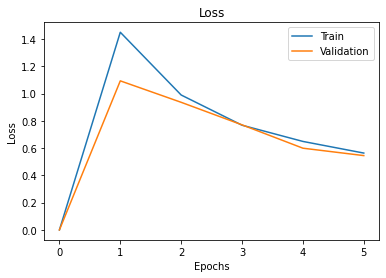

In [ ]:
ep = np.arange(0, epochs + 1,1)
plt.plot(ep, gcnTrainLoss, label="Train")
plt.plot(ep, gcnValLoss, label="Validation")

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

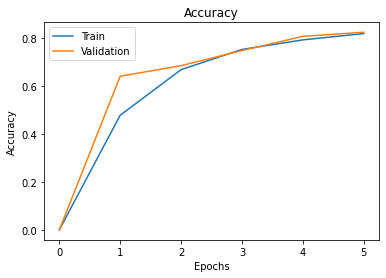

In [ ]:
ep = np.arange(0, epochs + 1,1)
plt.plot(ep, gcnTrainAcc, label="Train")
plt.plot(ep, gcnValAcc, label="Validation")

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

## Comparación

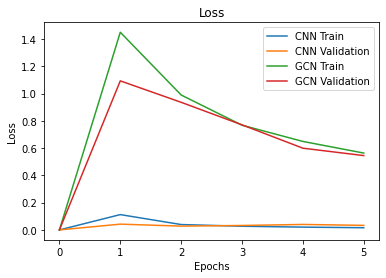

In [ ]:
ep = np.arange(0, epochs + 1,1)

plt.plot(ep, convTrainLoss, label="CNN Train")
plt.plot(ep, convValLoss, label="CNN Validation")

plt.plot(ep, gcnTrainLoss, label="GCN Train")
plt.plot(ep, gcnValLoss, label="GCN Validation")

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

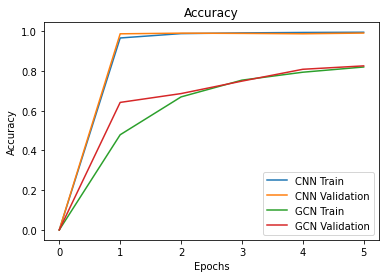

In [ ]:
ep = np.arange(0, epochs + 1,1)

plt.plot(ep, convTrainAcc, label="CNN Train")
plt.plot(ep, convValAcc, label="CNN Validation")

plt.plot(ep, gcnTrainAcc, label="GCN Train")
plt.plot(ep, gcnValAcc, label="GCN Validation")

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

In [ ]:
GCNmodel20 = GCN()

batch_size = 100
epochs = 20

gcnTrainLoss20, gcnValLoss20, gcnTrainAcc20, gcnValAcc20 = fit(GCNmodel20, dataloader, batch_size=batch_size, epochs=epochs)

Epoch 1/20 loss 1.46498 val_loss 1.08440 acc 0.47238 val_acc 0.63640
Epoch 2/20 loss 0.96069 val_loss 0.84307 acc 0.68002 val_acc 0.72190
Epoch 3/20 loss 0.75210 val_loss 0.63948 acc 0.75883 val_acc 0.80320
Epoch 4/20 loss 0.64589 val_loss 0.62271 acc 0.79470 val_acc 0.79670
Epoch 5/20 loss 0.56998 val_loss 0.53195 acc 0.81932 val_acc 0.83000
Epoch 6/20 loss 0.51114 val_loss 0.45722 acc 0.83755 val_acc 0.85340
Epoch 7/20 loss 0.46979 val_loss 0.42353 acc 0.85067 val_acc 0.86670
Epoch 8/20 loss 0.45175 val_loss 0.41513 acc 0.85583 val_acc 0.86450
Epoch 9/20 loss 0.42628 val_loss 0.40317 acc 0.86227 val_acc 0.87020
Epoch 10/20 loss 0.39812 val_loss 0.34889 acc 0.87277 val_acc 0.88910
Epoch 11/20 loss 0.37941 val_loss 0.36654 acc 0.87977 val_acc 0.88780
Epoch 12/20 loss 0.36683 val_loss 0.39120 acc 0.88302 val_acc 0.87530
Epoch 13/20 loss 0.34874 val_loss 0.32534 acc 0.88770 val_acc 0.89700
Epoch 14/20 loss 0.32560 val_loss 0.29976 acc 0.89588 val_acc 0.90770
Epoch 15/20 loss 0.30953 val_

In [ ]:
torch.save(GCNmodel20.state_dict(), "/content/drive/MyDrive/Tesis/GCNmodel20.pt")

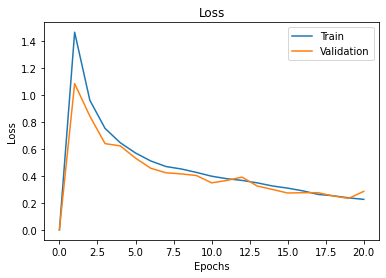

In [ ]:
ep = np.arange(0,epochs + 1,1)
plt.plot(ep, gcnTrainLoss20, label="Train")
plt.plot(ep, gcnValLoss20, label="Validation")

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

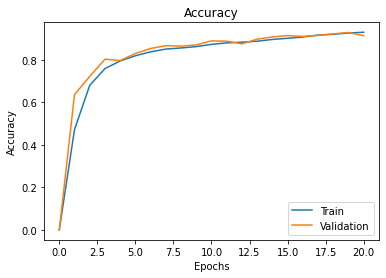

In [ ]:
ep = np.arange(0,epochs + 1,1)
plt.plot(ep, gcnTrainAcc20, label="Train")
plt.plot(ep, gcnValAcc20, label="Validation")

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.show()